<a href="https://colab.research.google.com/github/MingyangLou/DataXMindReader/blob/main/MindReader_Solution_w_Steps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and Importing Libraries

In [59]:
#Installing hmmlearn to build and train the HMM
!pip install hmmlearn
#Installing networkx to assign the HMM transition matrix to a graph
!pip install networkx
#Installing python-louvain to perform graph analysis on the HMM transition matrix
!pip install python-louvain

In [60]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hmmlearn as hmm
import networkx as nx
import community as lvcm
from hmmlearn.hmm import MultinomialHMM
import collections
import itertools
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from collections import Counter
from google.colab import drive

# Step 0: Loading and Cleaning the Data

In [61]:
#Mounting drive to be able to access data
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Volvo HMM Project/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1T01a1rxUdrfdS4tfGgwWks4bUw3sfNf0/Volvo HMM Project


In [62]:
#Dictionary matching page names to numbers, similar dictionary with time
page_dict = pd.read_csv('./Datasets/pagedict.csv')
gen_dict_withtime = pd.read_csv('./Datasets/gen_dict_withtime.csv')
#Converted User Page Sequences and Dwelling Times
c_pageseq = pd.read_csv('./Datasets/q4_cPageSeq.csv')
c_pageseqtimes = pd.read_csv('./Datasets/q4_cPageSeqTimes.csv')
#Non-Converted User Page Sequences and Dwelling Times
nc_pageseq = pd.read_csv('./Datasets/q4_ncPageSeq.csv')
nc_pageseqtimes = pd.read_csv('./Datasets/q4_ncPageSeqTimes.csv')

In [63]:
def page_preprocess(df):
    #Convert Sequence String to a List
    df['Page Sequence'] = df['seq'].apply(lambda x: [int(i) for i in x.split(",")])
    #Split IDs to Session ID and User ID
    df['Session ID'] = df.ids.apply(lambda x: x.split(',')[0])
    df['User ID'] = df.ids.apply(lambda x: x.split(',')[1])
    
def time_preprocess(df):
    #Split IDs to Session ID and User ID
    df['Session ID'] = df.ids.apply(lambda x: x.split(',')[0])
    df['User ID'] = df.ids.apply(lambda x: x.split(',')[1])

def combo_page_time(page, time):
    #Combining the Page and Time Sequence Datasets
    page['Time Sequence'] = time['seq']

In [64]:
#Preprocessing Data
page_preprocess(c_pageseq)
page_preprocess(nc_pageseq)
time_preprocess(c_pageseqtimes)
time_preprocess(nc_pageseqtimes)
combo_page_time(c_pageseq, c_pageseqtimes)
combo_page_time(nc_pageseq, nc_pageseqtimes)

In [65]:
#Setting up data as converted and non-converted
c_data = c_pageseq.copy()
nc_data = nc_pageseq.sample(len(c_data))

In [66]:
#Drop Redundant Columns and Making the Session the Index
c_data = c_data.drop(columns=['ids','seq', 'User ID'])
c_data = c_data.set_index('Session ID')
nc_data = nc_data.drop(columns=['ids','seq', 'User ID'])
nc_data = nc_data.set_index('Session ID')

In [67]:
#Restructing Time Sequences to Be Lists
c_data['Time Sequence'] = c_data['Time Sequence'].apply(lambda x: x[1:-1]).apply(lambda x: [float(i) for i in x.split(",")])
nc_data['Time Sequence'] = nc_data['Time Sequence'].apply(lambda x: x[1:-1]).apply(lambda x: [float(i) for i in x.split(",")])

In [68]:
#Adding a 0 to the front of Time Sequence for the included media channel
def add_zero(x):
    x.insert(0,0)
    return x
c_data['Time Sequence'] = c_data['Time Sequence'].apply(add_zero)
nc_data['Time Sequence'] = nc_data['Time Sequence'].apply(add_zero)

In [69]:
#Adding in total time and sequence lengths for potential later analysis
c_data['Total Time'] = c_data['Time Sequence'].apply(lambda x: sum(x))
c_data['Length'] = c_data['Page Sequence'].apply(lambda x: len(x))
nc_data['Total Time'] = nc_data['Time Sequence'].apply(lambda x: sum(x))
nc_data['Length'] = nc_data['Page Sequence'].apply(lambda x: len(x))

In [70]:
c_data.head()

,Page Sequence,Time Sequence,Total Time,Length
Session ID,,,,
1569880989,"[126, 74, 84, 74, 84, 24]","[0, 36.17, 8.08, 53.54, 55.54, 0.0]",153.33,6
1569881650,"[125, 95, 84, 24]","[0, 861.66, 15.93, 0.0]",877.59,4
1569882913,"[125, 77, 5, 74, 5, 74, 85, 90, 93, 99, 91, 92...","[0, 12.45, 32.84, 325.86, 14.4, 49.31, 55.66, ...",1584.89,19
1569883055,"[130, 79, 84, 79, 85, 90, 93, 99, 91, 92, 96, ...","[0, 16.87, 4.74, 25.1, 90.57, 12.48, 59.36, 15...",444.76,17
1569883489,"[125, 85, 90, 93, 99, 91, 92, 96, 95, 96, 95, ...","[0, 41.22, 38.56, 46.11, 20.3, 4.28, 13.7, 10....",1753.24,28


# Step 1: Prepare Data for HMM
1. Combine Page Sequence with Dwelling Time
2. Format New Sequence Properly for hmmlearn

In [71]:
#Here we combine Page Sequence with Dwelling Time
def convert_page_seq(x):
  new_seq = []
  for index, item in enumerate(x['Page Sequence']):
      # First map from uncleaned category to general category (without timing information)
      gen_idx = page_dict[page_dict['idx'] == item]['gen_idx'].iloc[0]
      if index > 0:
        time = x['Time Sequence'][index - 1]
        # If immediately leave
        if time <= 1:
          gen_idx = gen_idx + 200
          # If time spent > median, change to the "long version" of index
        elif time > gen_dict_withtime[gen_dict_withtime['gen_idx'] == gen_idx]['median_without_immleave'].iloc[0]:
            gen_idx = gen_idx + 100
      # if index = 0 (no time information) or time <= median
      new_seq.append(gen_idx)
  return new_seq

In [72]:
c_data['Final Sequence'] = c_data.apply(lambda x: convert_page_seq(x), axis = 1)
nc_data['Final Sequence'] = nc_data.apply(lambda x: convert_page_seq(x), axis = 1)

In [73]:
c_data['General Index Sequence'] = c_data['Page Sequence'].apply(lambda x: [page_dict[page_dict['idx'] == i]['gen_idx'].iloc[0] for i in x])
nc_data['General Index Sequence'] = nc_data['Page Sequence'].apply(lambda x: [page_dict[page_dict['idx'] == i]['gen_idx'].iloc[0] for i in x])

In [75]:
#Then we prepare both the converted and nonconverted data for hmmlearn
c_hmm_sequence = c_data['Final Sequence'].apply(lambda x: [[i] for i in x])
c_data['HMM Sequence'] = c_hmm_sequence
c_seqs_list = np.concatenate(c_hmm_sequence)
c_seqs_len = [len(i) for i in c_data['Final Sequence']]

nc_hmm_sequence = nc_data['Final Sequence'].apply(lambda x: [[i] for i in x])
nc_data['HMM Sequence'] = nc_hmm_sequence
nc_seqs_list = np.concatenate(nc_hmm_sequence)
nc_seqs_len = [len(i) for i in nc_data['Final Sequence']]

In [74]:
c_data.head()

,Page Sequence,Time Sequence,Total Time,Length,Final Sequence,General Index Sequence
Session ID,,,,,,
1569880989,"[126, 74, 84, 74, 84, 24]","[0, 36.17, 8.08, 53.54, 55.54, 0.0]",153.33,6,"[63, 231, 120, 31, 120, 134]","[63, 31, 20, 31, 20, 34]"
1569881650,"[125, 95, 84, 24]","[0, 861.66, 15.93, 0.0]",877.59,4,"[72, 207, 120, 134]","[72, 7, 20, 34]"
1569882913,"[125, 77, 5, 74, 5, 74, 85, 90, 93, 99, 91, 92...","[0, 12.45, 32.84, 325.86, 14.4, 49.31, 55.66, ...",1584.89,19,"[72, 217, 15, 31, 115, 31, 107, 107, 107, 107,...","[72, 17, 15, 31, 15, 31, 7, 7, 7, 7, 7, 7, 7, ..."
1569883055,"[130, 79, 84, 79, 85, 90, 93, 99, 91, 92, 96, ...","[0, 16.87, 4.74, 25.1, 90.57, 12.48, 59.36, 15...",444.76,17,"[80, 231, 120, 31, 107, 107, 7, 107, 7, 7, 7, ...","[80, 31, 20, 31, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3,..."
1569883489,"[125, 85, 90, 93, 99, 91, 92, 96, 95, 96, 95, ...","[0, 41.22, 38.56, 46.11, 20.3, 4.28, 13.7, 10....",1753.24,28,"[72, 207, 107, 107, 107, 107, 7, 7, 7, 107, 7,...","[72, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 7, 7, 7,..."


# Step 2: Train the HMM
Here we use the website data as emissions for the model and the hidden states represent users underlying intents. We create and train our HMMs using hmmlearn.


In [76]:
#In this stage, we train both converted and non-converted data on seperate HMMs
#We decided on using 30 hidden states to represent hidden intents
#We decided using this large number of states knowing we were going to cluster them into communities after
c_hmm = MultinomialHMM(n_components=30)
c_hmm.fit(c_seqs_list, c_seqs_len)

nc_hmm = MultinomialHMM(n_components=30)
nc_hmm.fit(nc_seqs_list, nc_seqs_len)

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=30,
               n_iter=10, params='ste',
               random_state=RandomState(MT19937) at 0x7FBB2FD22990,
               startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
               verbose=False)

# Step 3: Network Analysis
Here we combine the 30 hidden states into the best well-defined communities. Using networkx, we find the optimal number of communities by optimizing for modularity. Modularity measures the degree to which densely connected compartments within a system can be decoupled into separate communities which interact more among themselves rather than other communities.

In [77]:
#Here we use networkx to find the best partitions of the hidden states
partitions = []
for hmm in [c_hmm, nc_hmm]:
    #Turning transition matrix into a format to be entered into networkx
    page_trans = pd.DataFrame(hmm.transmat_).reset_index()
    page_network_probs = pd.melt(page_trans, id_vars='index', value_vars=list(page_trans.columns[1:]),  var_name='End', value_name='Trans_Prob')
    page_network_probs = page_network_probs.rename({"index": 'Start'}, axis =1)
    undirected_probs = page_network_probs.groupby(["Start","End"]).sum().reset_index()
    #Transferring the probabilites into graph form through python-louvain to find the partition with highest modularity
    undirected_page_network = nx.from_pandas_edgelist(undirected_probs, 'Start', 'End', create_using=nx.Graph(), edge_attr='Trans_Prob')
    partition = lvcm.best_partition(graph=undirected_page_network, partition=None, weight='Trans_Prob', resolution=1., randomize=True)
    partitions.append(partition)

In [78]:
c_community = defaultdict(list)
for key, val in sorted(partitions[0].items()):
    c_community[val].append(key)
nc_community = defaultdict(list)
for key, val in sorted(partitions[1].items()):
    nc_community[val].append(key)

# Step 4: Define Communities
1. Identify the hidden intents behind each sequence
2. Find the top pages for each hidden state

In [81]:
#Function to translate the numbers in the sequences to their actual page names
def getCategory(x):
  if x >= 200:
    x = x - 200
    return gen_dict_withtime[gen_dict_withtime['gen_idx'] == x].gen_cat.iloc[0] + ' Imm Leave'
  elif x >= 100:
    x = x - 100
    return gen_dict_withtime[gen_dict_withtime['gen_idx'] == x].gen_cat.iloc[0] + ' Long'
  else:
    return gen_dict_withtime[gen_dict_withtime['gen_idx'] == x].gen_cat.iloc[0]

In [82]:
#Predicting the hidden states behind each community
c_data['Hidden States'] = c_data['HMM Sequence'].apply(lambda x: c_hmm.predict(x))
nc_data['Hidden States'] = nc_data['HMM Sequence'].apply(lambda x: nc_hmm.predict(x))

In [83]:
#Converting the hidden states to identified communities from previous step
c_data['Hidden States'] = c_data['Hidden States'].apply(lambda x: [partitions[0][i] for i in x])
nc_data['Hidden States'] = nc_data['Hidden States'].apply(lambda x: [partitions[1][i] for i in x])

In [84]:
c_match_seq = c_data.apply(lambda x: list(zip(x['Hidden States'], x['Final Sequence'])), axis =1)
nc_match_seq = nc_data.apply(lambda x: list(zip(x['Hidden States'], x['Final Sequence'])), axis =1)

In [85]:
c_seq_set = list(itertools.chain.from_iterable(c_match_seq.to_list()))
nc_seq_set = list(itertools.chain.from_iterable(nc_match_seq.to_list()))

In [86]:
#Inputting each step in each sequence to a dictionary
c_m = collections.OrderedDict()
nc_m = collections.OrderedDict()
for x in c_seq_set:
    c_m.setdefault(x[0], []).append(x[1])
for x in nc_seq_set:
    nc_m.setdefault(x[0], []).append(x[1])

In [87]:
def TopTenPages(state, or_dict):
  toppages = pd.Series(or_dict[state]).value_counts()[:10]
  for page in toppages.index:
    print(f"{getCategory(int(page))}({toppages[page]/len(or_dict[state]):.2f}) ", end = " ")

In [88]:
#Finding the top ten pages most common pages for each occurance of a hidden state in converted sequences
for i in range(3):
  print(f"Intent {i+1}: {len(c_m[i])}")
  TopTenPages(i, c_m)
  print('\n')

Intent 1: 64616
Leads_getLocalPrice Long(0.17)  Submit_dealerContact Long(0.16)  ShoppingTools(0.13)  CarConfigurator_landing Long(0.09)  CarConfigurator_landing(0.09)  PDP(0.06)  CarConfigurator_options Imm Leave(0.06)  Leads_getLocalPrice(0.04)  PDP Long(0.03)  ShoppingTools Long(0.03)  

Intent 2: 87729
CarConfigurator_options Long(0.40)  CarConfigurator_options(0.33)  CarConfigurator_Finish Imm Leave(0.08)  CarConfigurator_options Imm Leave(0.08)  CarebyVolvo_checkout(0.04)  CarebyVolvo_submit Long(0.03)  CarebyVolvo_checkout Long(0.02)  CarConfigurator_landing Long(0.01)  CarConfigurator_Finish(0.01)  CarConfigurator_landing Imm Leave(0.01)  

Intent 3: 24420
organic(0.15)  PDP Imm Leave(0.15)  HomePage Imm Leave(0.14)  cpc(0.12)  Other(0.12)  social(0.07)  CarebyVolvo_landingPage Imm Leave(0.06)  ShoppingTools Imm Leave(0.06)  CarConfigurator_landing Imm Leave(0.04)  referral(0.02)  



In [89]:
#Finding the top ten pages most common pages for each occurance of a hidden state in non-converted sequences
for i in range(4):
  print(f"Intent {i+1}: {len(nc_m[i])}")
  TopTenPages(i, nc_m)
  print('\n')

Intent 1: 6123
CarConfigurator_options Imm Leave(0.38)  CarConfigurator_landing(0.32)  CarConfigurator_landing Long(0.14)  CarConfigurator_options Long(0.08)  CarConfigurator_landing Imm Leave(0.04)  CarebyVolvo_landingPage Long(0.01)  CarebyVolvo_landingPage(0.01)  CarConfigurator_options(0.00)  CarConfigurator_Finish Imm Leave(0.00)  HomePage Long(0.00)  

Intent 2: 24455
PDP Imm Leave(0.19)  HomePage Imm Leave(0.15)  cpc(0.14)  Other(0.13)  organic(0.12)  social(0.06)  CarConfigurator_landing Imm Leave(0.04)  ShoppingTools Imm Leave(0.03)  CarebyVolvo_landingPage Imm Leave(0.03)  referral(0.02)  

Intent 3: 30087
CarConfigurator_options(0.40)  CarConfigurator_options Long(0.39)  CarConfigurator_options Imm Leave(0.09)  CarConfigurator_Finish Imm Leave(0.08)  CarConfigurator_landing Long(0.01)  Leads_getLocalPrice Long(0.01)  CarConfigurator_landing(0.01)  CarConfigurator_Finish(0.01)  CarConfigurator_Finish Long(0.00)  Leads_getLocalPrice(0.00)  

Intent 4: 13340
PDP(0.21)  CarConfi

# Step 5: Clustering Sessions
1. Create feature vectors of the porportion of hidden intents in each sequence
2. Find the optimal number of clusters using the Davies-Bouldin score. This score is similar to modularity but used for k-means clustering - it  measures the strength and independence of each cluster.
3. Use the number of clusters with the lowest Davies-Bouldin score to cluster the sessions.

In [92]:
#Here we create a vector for each session
#Each vector contains the proportion of hidden states in the session
hidden_states = [np.arange(0, 3), np.arange(0,4)]
session_vector = [[], []]
for i, data in enumerate([c_data, nc_data]):
    for seq in data['Hidden States']:
      length = len(seq)
      dict = Counter(seq)
      vector = []
      for key in hidden_states[i]:
        vector.append(dict[key] / length)
      session_vector[i].append(vector)
c_sample_vector = c_data.copy()
nc_sample_vector = nc_data.copy()
c_sample_vector['Vector'] = session_vector[0]
nc_sample_vector['Vector'] = session_vector[1]

In [93]:
#Here we find the Davies-Bouldin score for 2-20 clusters of sessions
c_davies_scores = []
nc_davies_scores = []
for n in np.arange(2, 21):
    kmeans = KMeans(n_clusters=n).fit(c_sample_vector['Vector'].tolist())
    labels = kmeans.labels_
    c_davies_scores.append(davies_bouldin_score(c_sample_vector['Vector'].tolist(), labels))
    kmeans = KMeans(n_clusters=n).fit(nc_sample_vector['Vector'].tolist())
    labels = kmeans.labels_
    nc_davies_scores.append(davies_bouldin_score(nc_sample_vector['Vector'].tolist(), labels))

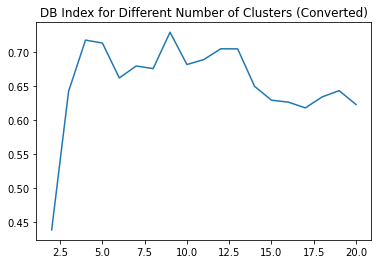

In [94]:
#Here we plot the Davies-Bouldin index for number of clusters of converted sessions 
#We find the low point along the plot and use that number of clusters as the optimal number of clusters
kmeans_scores = pd.Series(c_davies_scores, index=np.arange(2, 21))
plt.title('DB Index for Different Number of Clusters (Converted)')
plt.plot(kmeans_scores);

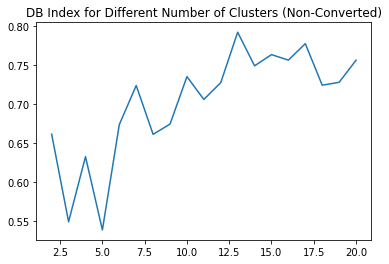

In [95]:
#Here we plot the Davies-Bouldin index for number of clusters of non-converted sessions 
#Again we find the low point along the plot and use that number of clusters as the optimal number of clusters
kmeans_scores = pd.Series(nc_davies_scores, index=np.arange(2, 21))
plt.title('DB Index for Different Number of Clusters (Non-Converted)')
plt.plot(kmeans_scores);

In [103]:
#Here we do k-means clustering of each session in each dataset using the optimal number of clusters
kmeans = KMeans(n_clusters=2).fit(c_sample_vector['Vector'].tolist())
c_sample_vector['User Type'] = kmeans.labels_

kmeans = KMeans(n_clusters=5).fit(nc_sample_vector['Vector'].tolist())
nc_sample_vector['User Type'] = kmeans.labels_

In [104]:
#Prepare the converted dataset so that we can analyze the different sessions
c_session_clusters = []
for i in np.arange(0,2):
  temp = c_sample_vector[c_sample_vector['User Type'] == i]
  total = np.array([0, 0, 0])
  for vec in temp['Vector']:
    vec = np.array(vec)
    total = total + vec
  avg = total / len(temp)
  full = np.append(avg, [len(temp), np.mean(temp['Length'])])
  c_session_clusters.append(full)

In [105]:
col = ['Intent 1', 'Intent 2', 'Intent 3', 'Number of Sessions', 'Average Session Length']
c_session_types = pd.DataFrame(c_session_clusters, index=['Session 1', 'Session 2'], columns=col)

In [106]:
c_session_types

,Intent 1,Intent 2,Intent 3,Number of Sessions,Average Session Length
Session 1,0.656104,0.032147,0.311749,5394.0,7.674082
Session 2,0.252938,0.621334,0.125728,7287.0,18.577055


In [111]:
#Prepare the non-converted dataset so that we can analyze the different sessions
nc_session_clusters = []
for i in np.arange(0,5):
  temp = nc_sample_vector[nc_sample_vector['User Type'] == i]
  total = np.array([0, 0, 0, 0])
  for vec in temp['Vector']:
    vec = np.array(vec)
    total = total + vec
  avg = total / len(temp)
  full = np.append(avg, [len(temp), np.mean(temp['Length'])])
  nc_session_clusters.append(full)

In [112]:
col = ['Intent 1', 'Intent 2', 'Intent 3', 'Intent 4', 'Number of Sessions', 'Average Session Length']
nc_session_types = pd.DataFrame(nc_session_clusters, index=['Session 1', 'Session 2', 'Session 3', 'Session 4', 'Session 5'], columns=col)

In [113]:
nc_session_types

,Intent 1,Intent 2,Intent 3,Intent 4,Number of Sessions,Average Session Length
Session 1,0.000000,0.666010,0.000985,0.333005,1777.0,3.003939
Session 2,0.000000,1.000000,0.000000,0.000000,4220.0,2.000000
Session 3,0.082265,0.156287,0.673756,0.087692,2756.0,15.152758
Session 4,0.022374,0.410397,0.010427,0.556802,2376.0,5.166667
Session 5,0.348091,0.505227,0.081034,0.065648,1552.0,3.988402
